In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

def rmse(y, yhat):
    return np.mean((y.flatten() - yhat.flatten())**2)

In [3]:
dgp = 1

In [4]:
if dgp == 1:
    # dgp that favors the x-learner
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: .5 * np.ones(z.shape)

In [5]:
if dgp == 2:
    # dgp that favors the dr-learner
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: (.5 + .1 * (z<=.4) * (z>=.2))

In [6]:
if dgp == 3:
    # dgp that favors the r-learner
    prop = lambda z: .5 - .4 * (z<=.6) * (z>=.3) + .4 * (z>=.65)
    base = lambda z: .1 * (z>=.7)
    cate = lambda z: .5 * z**2

In [7]:
if dgp == 4:
    # dgp that favors the covariate shift X-learner over X-learner
    prop = lambda z: .5 - .49 * (z<=.6) * (z>=.3)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: .5 * z**2 * (z<=.6) + .18

In [8]:
if dgp == 5:
    # dgp that removes superiority of X-learner strategy
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * np.ones(z.shape)
    cate = lambda z: .5 * (z<=.8) * (z>=.5)

In [9]:
if dgp == 6:
    # dgp that favors the opposite of the X-learner strategy
    prop = lambda z: .95 * np.ones(z.shape)
    base = lambda z: .1 * np.ones(z.shape)
    cate = lambda z: .5 * (z<=.8) * (z>=.5)

In [10]:
np.random.seed(12)
n = 1000
nval = 1000
Z = np.random.uniform(0, 1, size=n)
D = np.random.binomial(1, prop(Z))
Y = cate(Z) * D + base(Z) + np.random.normal(0, .05, size=n)

In [11]:
ntest = 1000
Ztest = np.random.uniform(0, 1, size=ntest)
Ztest = np.sort(Ztest)

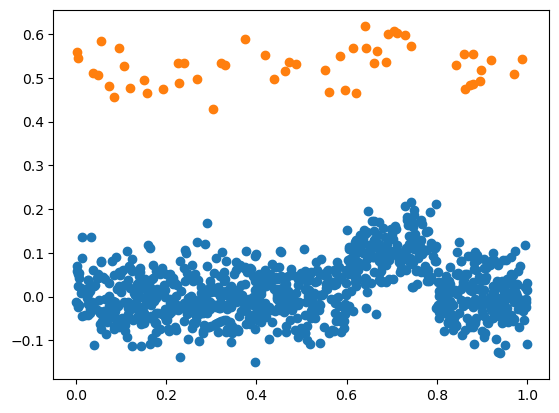

In [12]:
import matplotlib.pyplot as plt

plt.scatter(Z[D==0], Y[D==0])
plt.scatter(Z[D==1], Y[D==1])
plt.show()

In [13]:
from myxgb import xgb_reg, xgb_clf, xgb_wreg
reg = xgb_reg
clf = xgb_clf
wreg = xgb_wreg

In [14]:
Z = Z.reshape(-1, 1)
g0 = reg().fit(Z[D==0], Y[D==0])
g1 = reg().fit(Z[D==1], Y[D==1])

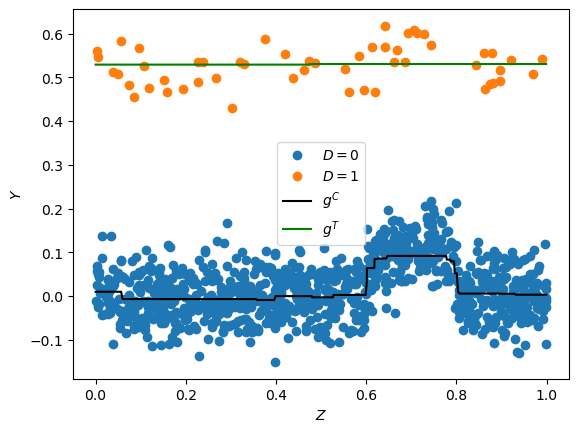

In [15]:
plt.scatter(Z[D==0], Y[D==0], label='$D=0$')
plt.scatter(Z[D==1], Y[D==1], label='$D=1$')
plt.plot(Ztest, g0.predict(Ztest.reshape(-1, 1)), color='black', label='$g^C$')
plt.plot(Ztest, g1.predict(Ztest.reshape(-1, 1)), color='green', label='$g^T$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [16]:
# from aggregation import experiment_dr, experiment

# mses, cates, nuisances = experiment(dgp=dgp, n=n, scale=0.05, random_state=123, reg=reg, clf=clf)

In [17]:
# inds = np.argsort(nuisances['train']['Zval'].flatten())
# plt.plot(nuisances['train']['Zval'][inds], nuisances['train']['g0'][inds], label='$D=0$')
# plt.plot(nuisances['train']['Zval'][inds], nuisances['train']['g1'][inds], label='$D=1$')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
# plt.legend()
# plt.show()

In [18]:
# propensity
mu = clf().fit(Z, D)

In [19]:
# X-learner
m = mu.predict_proba(Z)[:, 1]
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0])
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]))

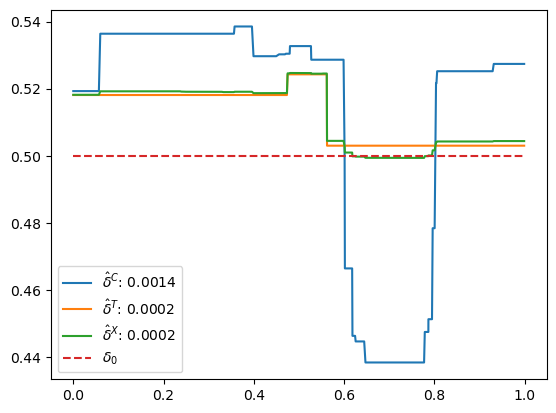

In [20]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, t0,  label='$\hat{\delta}^C$: ' + f'{rmse(cate(Ztest), t0):.4f}')
plt.plot(Ztest, t1, label='$\hat{\delta}^T$: ' + f'{rmse(cate(Ztest), t1):.4f}')
plt.plot(Ztest, tX,  label='$\hat{\delta}^X$: ' + f'{rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label='$\delta_0$')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
plt.legend()
plt.show()

In [21]:
# S-Learner
g = reg().fit(np.hstack([D.reshape(-1, 1), Z]), Y)

In [22]:
# IPS-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauIPS = reg().fit(Z, Y * (D - m)/cov)

In [23]:
# DR-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1.predict(Z)
g0preds = g0.predict(Z)
gpreds = g1preds * D + g0preds * (1 - D)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDR = reg().fit(Z, Ydr)

In [24]:
# R-Learner
h = reg().fit(Z, Y)
Yres = Y - h.predict(Z)
Dres = D - mu.predict_proba(Z)[:, 1]

In [25]:
DresClip = np.clip(Dres, 1e-12, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -1e-12) * (Dres<0)
tauR = wreg().fit(Z, Yres/DresClip, sample_weight=Dres**2)

C:\Users\bsyrg\AppData\Roaming\Python\Python310\site-packages\econml\sklearn_extensions\model_selection.py:60: UserWarning: The KFold algorithm failed to find a weight-balanced partition after 10 trials. Falling back on a weight stratification algorithm.
  warnings.warn("The KFold algorithm failed to find a weight-balanced partition after " +


In [26]:
# from econml.grf import CausalForest
# tauR = CausalForest(min_samples_leaf=20, max_depth=5, max_samples=.8, inference=False).fit(Z, Dres, Yres)

In [27]:
# DRX-Learner
m = mu.predict_proba(Z)[:, 1]
g0preds = g0.predict(Z)
g1preds = g1.predict(Z)
g0preds = g0preds * (1 - m) + (g1.predict(Z) - tau0.predict(Z)) * m
g1preds = g1preds * m + (g0.predict(Z) + tau1.predict(Z)) * (1 - m)
gpreds = g1preds * D + g0preds * (1 - D)
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDRX = reg().fit(Z, Ydr)

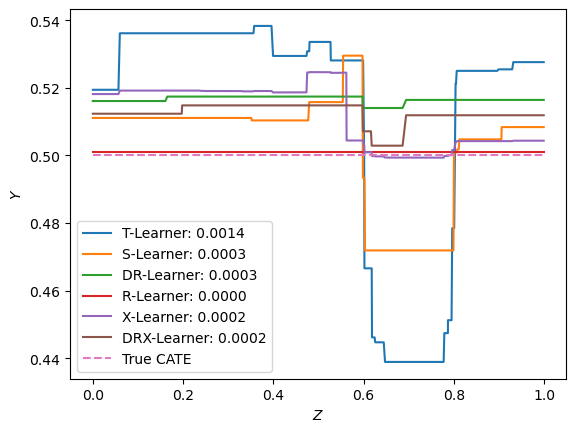

In [28]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
tT = g1.predict(Ztest.reshape(-1, 1)) - g0.predict(Ztest.reshape(-1, 1))
tS = g.predict(np.stack((np.ones(ntest), Ztest), -1)) - g.predict(np.stack((np.zeros(ntest), Ztest), -1))
tIPS = tauIPS.predict(Ztest.reshape(-1, 1))
tDR = tauDR.predict(Ztest.reshape(-1, 1))
tR = tauR.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
plt.plot(Ztest, tT, label=f'T-Learner: {rmse(cate(Ztest), tT):.4f}')
plt.plot(Ztest, tS, label=f'S-Learner: {rmse(cate(Ztest), tS):.4f}')
# plt.plot(Ztest, tIPS, label='IPS-Learner')
plt.plot(Ztest, tDR, label=f'DR-Learner: {rmse(cate(Ztest), tDR):.4f}')
plt.plot(Ztest, tR, label=f'R-Learner: {rmse(cate(Ztest), tR):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [29]:
# plt.plot(cates['Ztest'], cates['S'], label=f"T-LearnerQ: {mses['S']:.4f}")
# plt.plot(Ztest, tS, label=f'T-Learner: {rmse(cate(Ztest), tS):.4f}')
# plt.plot(cates['Ztest'], cate(cates['Ztest']), '--', label=f'True CATE')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
# plt.legend()
# plt.show()

In [30]:
import scipy

def instance(nu, U, y):
    n = y.shape[0]
    ploss = np.mean((y.reshape(1, -1) - U)**2, axis=1)

    def loss(x):
        return np.mean((y - U.T @ x)**2)

    def qfunction(x):
        return (1 - nu) * loss(x) + nu * x @ ploss

    def grad_q(x):
        return - 2 * (1 - nu) * U @ (y - U.T @ x) / n + nu * ploss

    return loss, qfunction, grad_q, ploss

def opt(K, qfunction, grad_q):
    res = scipy.optimize.minimize(qfunction, np.ones(K)/K, jac=grad_q, bounds=[(0, 1)]*K,
                                  constraints=scipy.optimize.LinearConstraint(np.ones((1, K)), lb=1, ub=1),
                                  tol=1e-12)
    return res.x

def qagg(F, y):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(.5, F.T / scale, y / scale)
    return opt(F.shape[1], qfunction, grad_q)

In [31]:
def staragg(F, y):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(.5, F.T / scale, y / scale)
    sol = np.zeros(F.shape[1])
    best = np.argmin(ploss)
    sol[best] = 1.0
    best_loss = loss(sol)
    best_sol = sol
    for gamma in np.linspace(0, 1, 100):
        for i in range(F.shape[1]):
            x = (1 - gamma) * sol
            x[i] += gamma
            cur_loss = loss(x)
            if cur_loss < best_loss:
                best_loss = cur_loss
                best_sol = x
    return best_sol

In [32]:
Zval = np.random.uniform(0, 1, size=n)
Dval = np.random.binomial(1, prop(Zval))
Yval = cate(Zval) * Dval + base(Zval) + np.random.normal(0, .05, size=n)

In [33]:
Zval = Zval.reshape(-1, 1)
g0val = reg().fit(Zval[Dval==0], Yval[Dval==0])
g1val = reg().fit(Zval[Dval==1], Yval[Dval==1])
muval = clf().fit(Zval, Dval)
# DR-Learner
m = muval.predict_proba(Zval)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1val.predict(Zval)
g0preds = g0val.predict(Zval)
gpreds = g1preds * Dval + g0preds * (1 - Dval)
Ydrval = (Yval - gpreds) * (Dval - m)/cov + g1preds - g0preds

In [34]:
t0 = tau0.predict(Zval)
t1 = tau1.predict(Zval)
tT = g1.predict(Zval) - g0.predict(Zval)
tS = g.predict(np.stack((np.ones(n), Zval.flatten()), -1))
tS -= g.predict(np.stack((np.zeros(n), Zval.flatten()), -1))
tIPS = tauIPS.predict(Zval)
tDR = tauDR.predict(Zval)
tR = tauR.predict(Zval)
m = mu.predict_proba(Zval)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Zval)

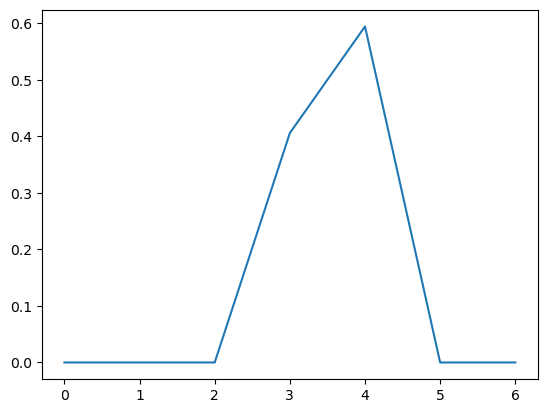

In [35]:
F = np.stack((tT, tS, tIPS, tDR, tR, tX, tDRX), -1)
weights = qagg(F, Ydrval)
plt.plot(weights)
# weights = staragg(F, Ydrval)
# plt.plot(weights)

In [36]:
f'Ensemble: {rmse(cate(Zval.flatten()), F @ weights):.4f}'

'Ensemble: 0.0001'

In [37]:
weightsBest = np.zeros(weights.shape)
weightsBest[np.argmin(np.mean((Ydrval.reshape(-1, 1) - F)**2, axis=0))] = 1.0
f'Ensemble: {rmse(cate(Zval.flatten()), F @ weightsBest):.4f}'

'Ensemble: 0.0000'

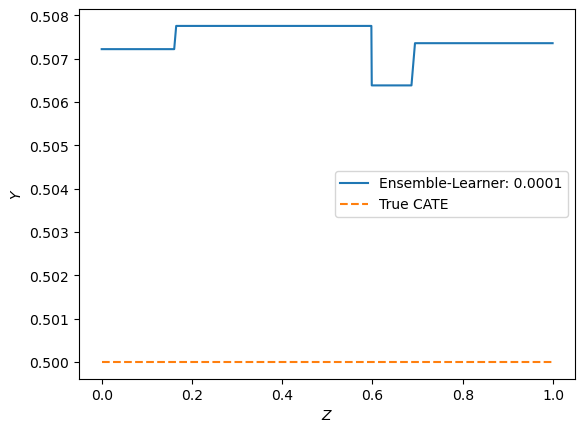

In [38]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
tT = g1.predict(Ztest.reshape(-1, 1)) - g0.predict(Ztest.reshape(-1, 1))
tS = g.predict(np.stack((np.ones(ntest), Ztest), -1)) - g.predict(np.stack((np.zeros(ntest), Ztest), -1))
tIPS = tauIPS.predict(Ztest.reshape(-1, 1))
tDR = tauDR.predict(Ztest.reshape(-1, 1))
tR = tauR.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
F = np.stack((tT, tS, tIPS, tDR, tR, tX, tDRX), -1)
tE = F @ weights
plt.plot(Ztest, tE, label=f'Ensemble-Learner: {rmse(cate(Ztest), tE):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [39]:
# plt.plot(Ztest, tE, label=f'Ensemble-Learner: {rmse(cate(Ztest), tE):.4f}')
# plt.plot(cates['Ztest'], cates['Qval'], label=f"T-LearnerQ: {mses['Qval']:.4f}")
# plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
# plt.legend()
# plt.show()

In [40]:
# re-weighted drlearner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauDRXW = wreg().fit(Z, Ydr, sample_weight=cov**2)

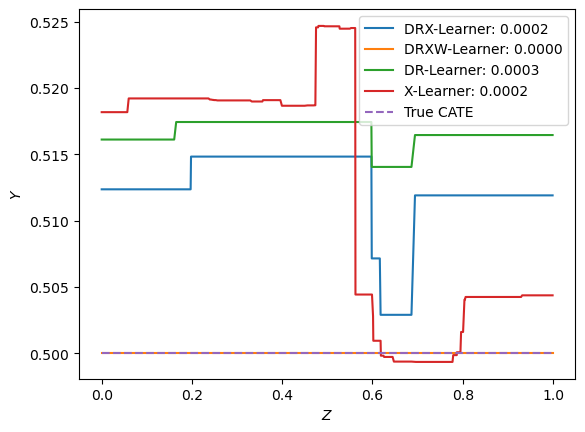

In [41]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
tDRXW = tauDRXW.predict(Ztest.reshape(-1, 1))
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, tDRXW, label=f'DRXW-Learner: {rmse(cate(Ztest), tDRXW):.4f}')
plt.plot(Ztest, tDR, label=f'DR-Learner: {rmse(cate(Ztest), tDR):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [42]:
# post-processing DRX
m = mu.predict_proba(Z)[:, 1]
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
tX = t1 * (1 - m) + t0 * m
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = tX + (Yres - tX * Dres) * Dres / cov
tauDRX = reg().fit(Z, Ydr)

In [43]:
# post-processing RX
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
m = mu.predict_proba(Z)[:, 1]
tX = t1 * (1 - m) + t0 * m
Dres = D - mu.predict_proba(Z)[:, 1]
DresClip = np.clip(Dres, 1e-12, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -1e-12) * (Dres<0)
tauRX = wreg().fit(Z, Yres/DresClip - tX, sample_weight=DresClip**2)
# tauR = wreg().fit(Z, Yres/DresClip, sample_weight=Dres**2)

C:\Users\bsyrg\AppData\Roaming\Python\Python310\site-packages\econml\sklearn_extensions\model_selection.py:60: UserWarning: The KFold algorithm failed to find a weight-balanced partition after 10 trials. Falling back on a weight stratification algorithm.
  warnings.warn("The KFold algorithm failed to find a weight-balanced partition after " +


In [44]:
from sklearn.linear_model import LinearRegression
tauRX = LinearRegression().fit(Z, Yres/DresClip - tX, sample_weight=DresClip**2)

In [45]:
tauRX.coef_

array([0.00320219])

In [46]:
tauRX.intercept_

-0.009794686622146428

In [47]:
np.mean(tX)

0.5117823

In [48]:
np.mean(Yres/DresClip - tX)

-0.03722677819341511

In [49]:
np.mean(tauRX.predict(Z))

-0.008152629490893504

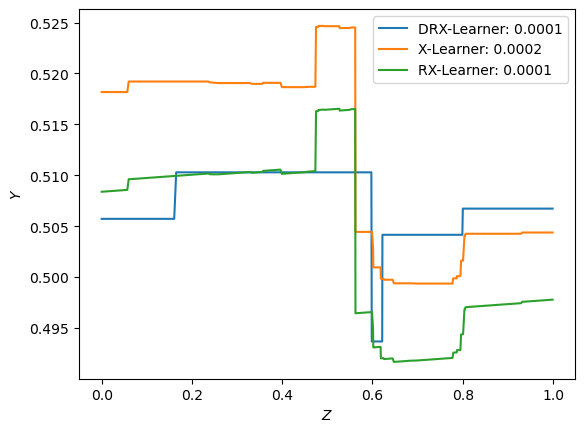

In [50]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
tX = t1 * (1 - m) + t0 * m
tRX = tauRX.predict(Ztest.reshape(-1, 1)) + tX
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, tRX, label=f'RX-Learner: {rmse(cate(Ztest), tRX):.4f}')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [51]:
# correcting for covariate shift in CATE model estimation in X-Learner
m = mu.predict_proba(Z)[:, 1]

g0 = wreg().fit(Z[D==0], Y[D==0], sample_weight=(1 - m[D==0]))
g1 = wreg().fit(Z[D==1], Y[D==1], sample_weight=m[D==1])
tau0 = wreg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0], sample_weight=m[D==0]**2 / (1 - m[D==0]))
tau1 = wreg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]), sample_weight=(1 - m[D==1])**2 / m[D==1])

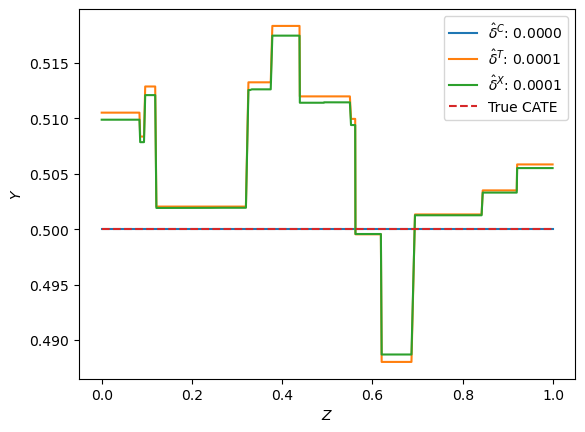

In [52]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, t0,  label='$\hat{\delta}^C$: ' + f'{rmse(cate(Ztest), t0):.4f}')
plt.plot(Ztest, t1, label='$\hat{\delta}^T$: ' + f'{rmse(cate(Ztest), t1):.4f}')
plt.plot(Ztest, tX,  label='$\hat{\delta}^X$: ' + f'{rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [53]:
# from sklearn.model_selection import cross_val_predict, KFold

# m = cross_val_predict(clf(), Z, D, method='predict_proba')[:, 1]
# g0preds, g1preds = np.zeros(Y.shape), np.zeros(Y.shape)
# for train, test in KFold().split(Z, D):
#     g1preds[test] = reg().fit(Z[train][D[train]==1], Y[train][D[train]==1]).predict(Z[test])
#     g0preds[test] = reg().fit(Z[train][D[train]==0], Y[train][D[train]==0]).predict(Z[test])

# gpreds = g1preds * D + g0preds * (1 - D)
# Ydr = (Y - gpreds) * (D - m)/(m * (1 - m)) + g1preds - g0preds
# tauDR = reg().fit(Z, Ydr)

In [54]:
# grid = np.linspace(0, 1, 20)

# t0 = tau0.predict(grid.reshape(-1, 1))
# t1 = tau1.predict(grid.reshape(-1, 1))
# tDR = tauDR.predict(grid.reshape(-1, 1))
# m = mu.predict_proba(grid.reshape(-1, 1))[:, 1]
# plt.plot(grid, tDR, label='DR-Learner')
# plt.plot(grid, t1 * (1 - m) + t0 * m,  label='X-Learner')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
# plt.legend()
# plt.show()